In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from portfolio import Portfolio
from backtest import fine_tuning_k_means, backtest_fun, plot_results_backtest

# Define Investment Universe

We are focused on portfolio optimisation, and not stock picking.\
Thus for simplicty, our investment universe will be the current S&P 500 constituents with daily price data from 2000 to 2024.

In [2]:
# Get current constituents of S&P 500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [3]:
# Get price data from yfinance
prices = yf.download(sp500['Symbol'].tolist(), auto_adjust=False,
                     start='2000-01-01', end='2024-12-31')['Adj Close']
prices.head()

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2024-12-31)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.199890,0.840094,NaN,NaN,8.170224,1.215037,NaN,16.274672,27.847197,6.116467,...,11.114000,NaN,6.680140,17.406443,NaN,NaN,4.567842,NaN,25.027779,NaN
2000-01-04,39.899902,0.769266,NaN,NaN,7.936790,1.208433,NaN,14.909399,26.438427,6.052755,...,10.696478,NaN,6.833959,17.073050,NaN,NaN,4.476027,NaN,24.666668,NaN
2000-01-05,37.424911,0.780523,NaN,NaN,7.922198,1.320692,NaN,15.204174,26.824394,5.957185,...,11.263110,NaN,7.097647,18.003801,NaN,NaN,4.498979,NaN,25.138889,NaN
2000-01-06,35.999897,0.712977,NaN,NaN,8.199407,1.307485,NaN,15.328288,26.091057,5.989039,...,11.789988,NaN,7.031728,18.934546,NaN,NaN,4.460725,NaN,23.777779,NaN
2000-01-07,38.999893,0.746750,NaN,NaN,8.286941,1.380124,NaN,16.072983,26.824394,6.084614,...,11.402286,NaN,7.031728,18.878986,NaN,NaN,4.361256,NaN,23.513889,NaN


In [4]:
# Filter only stocks that have daily price data throughout time period
prices = prices.dropna(axis=1)
prices.to_csv('data/prices.csv')

sp500 = sp500[sp500['Symbol'].isin(prices.columns)]
sp500 = sp500.sort_values(by='Symbol').reset_index(drop=True)
sp500.to_csv('data/sp500.csv')

sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ACGL,Arch Capital Group,Financials,Property & Casualty Insurance,"Hamilton, Bermuda",2022-11-01,947484,1995
4,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
...,...,...,...,...,...,...,...,...
344,WY,Weyerhaeuser,Real Estate,Timber REITs,"Seattle, Washington",1979-10-01,106535,1900
345,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
346,XOM,ExxonMobil,Energy,Integrated Oil & Gas,"Irving, Texas",1957-03-04,34088,1999
347,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997


# Community Portfolio

In [5]:
# data_csv = pd.read_csv('data/SandP500.csv')
# data_csv.head()

data_csv = sp500[['Symbol', 'Security', 'GICS Sector']]
data_csv.columns = ['Symbol', 'Name', 'Sector']
data_csv = data_csv.sort_values(by='Symbol').reset_index(drop=True)
data_csv.head()

,Symbol,Name,Sector
0,A,Agilent Technologies,Health Care
1,AAPL,Apple Inc.,Information Technology
2,ABT,Abbott Laboratories,Health Care
3,ACGL,Arch Capital Group,Financials
4,ADBE,Adobe Inc.,Information Technology


In [6]:
# price_data =  pd.read_csv('data/price_data.csv', index_col=0)

price_data =  pd.read_csv('data/prices.csv', index_col=0)
price_data.head()

,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WRB,WSM,WST,WY,XEL,XOM,YUM,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,43.199890,0.840094,8.170224,1.215037,16.274672,27.847197,6.116467,24.090567,8.052906,10.261162,...,8.934744,14.239625,0.791328,6.958397,5.405025,11.114000,6.680140,17.406443,4.567842,25.027779
2000-01-04,39.899902,0.769266,7.936790,1.208433,14.909399,26.438427,6.052755,24.090567,7.660816,10.261162,...,8.736597,13.706797,0.766980,6.739077,5.460863,10.696478,6.833959,17.073050,4.476027,24.666668
2000-01-05,37.424911,0.780523,7.922198,1.320692,15.204174,26.824394,5.957185,23.858927,7.178245,10.658115,...,9.277002,13.427075,0.754805,6.778956,5.438526,11.263110,7.097647,18.003801,4.498979,25.138889
2000-01-06,35.999897,0.712977,8.199407,1.307485,15.328288,26.091057,5.989039,24.177433,6.740915,10.618423,...,9.475150,13.573605,0.798633,5.423164,5.382690,11.789988,7.031728,18.934546,4.460725,23.777779
2000-01-07,38.999893,0.746750,8.286941,1.380124,16.072983,26.824394,6.084614,24.727579,7.540174,10.777199,...,9.727339,14.599279,0.786458,5.333441,5.438526,11.402286,7.031728,18.878986,4.361256,23.513889


In [7]:
portfolio = Portfolio(data_csv, price_data = price_data)
portfolio.compute_return()

,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WRB,WSM,WST,WY,XEL,XOM,YUM,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.076389,-0.084310,-0.028571,-0.005435,-0.083889,-0.050589,-0.010416,0.000000,-0.048689,0.000000,...,-0.022177,-0.037419,-0.030770,-0.031519,0.010331,-0.037567,0.023026,-0.019153,-0.020100,-0.014428
2000-01-05,-0.062030,0.014633,-0.001838,0.092896,0.019771,0.014599,-0.015790,-0.009615,-0.062992,0.038685,...,0.061855,-0.020407,-0.015873,0.005918,-0.004090,0.052974,0.038585,0.054516,0.005128,0.019144
2000-01-06,-0.038077,-0.086538,0.034991,-0.010000,0.008163,-0.027338,0.005347,0.013350,-0.060924,-0.003724,...,0.021359,0.010913,0.058065,-0.200000,-0.010267,0.046779,-0.009288,0.051697,-0.008503,-0.054144
2000-01-07,0.083333,0.047369,0.010676,0.055556,0.048583,0.028107,0.015958,0.022755,0.118568,0.014953,...,0.026616,0.075564,-0.015244,-0.016544,0.010373,-0.032884,0.000000,-0.002934,-0.022299,-0.011098
2000-01-10,0.060577,-0.017588,-0.007042,0.033493,0.038610,0.087051,0.000000,0.024590,-0.010100,-0.007366,...,-0.018518,-0.018248,-0.009288,0.033645,0.020534,-0.004359,0.000000,-0.013981,0.040351,0.033668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.000669,0.003065,0.000700,0.012089,-0.000962,0.014685,-0.001585,0.000442,-0.002113,0.004480,...,0.010469,-0.020490,-0.002732,0.015462,-0.005522,0.021091,0.004748,0.004062,0.011333,-0.006081
2024-12-24,0.011144,0.011478,0.003937,0.006298,0.002686,0.014891,0.004364,0.007853,0.012572,0.013379,...,0.010176,0.025789,0.005136,0.006487,0.009710,0.006410,0.007236,0.000941,0.008516,0.012262
2024-12-26,-0.001984,0.003176,0.004444,0.002806,0.004956,-0.000138,-0.000395,0.002597,-0.003154,-0.002200,...,-0.011722,0.001187,0.008687,-0.000533,0.001983,-0.003185,-0.000440,0.000846,0.007407,0.003566


## Stability

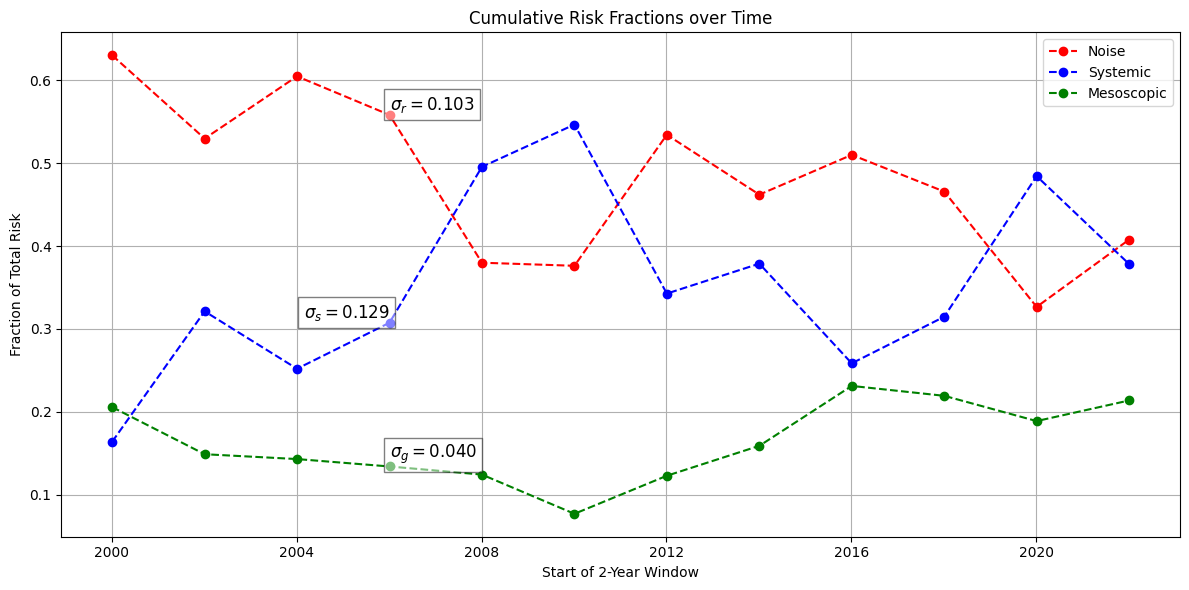

In [8]:
portfolio.plot_stability()

## Community

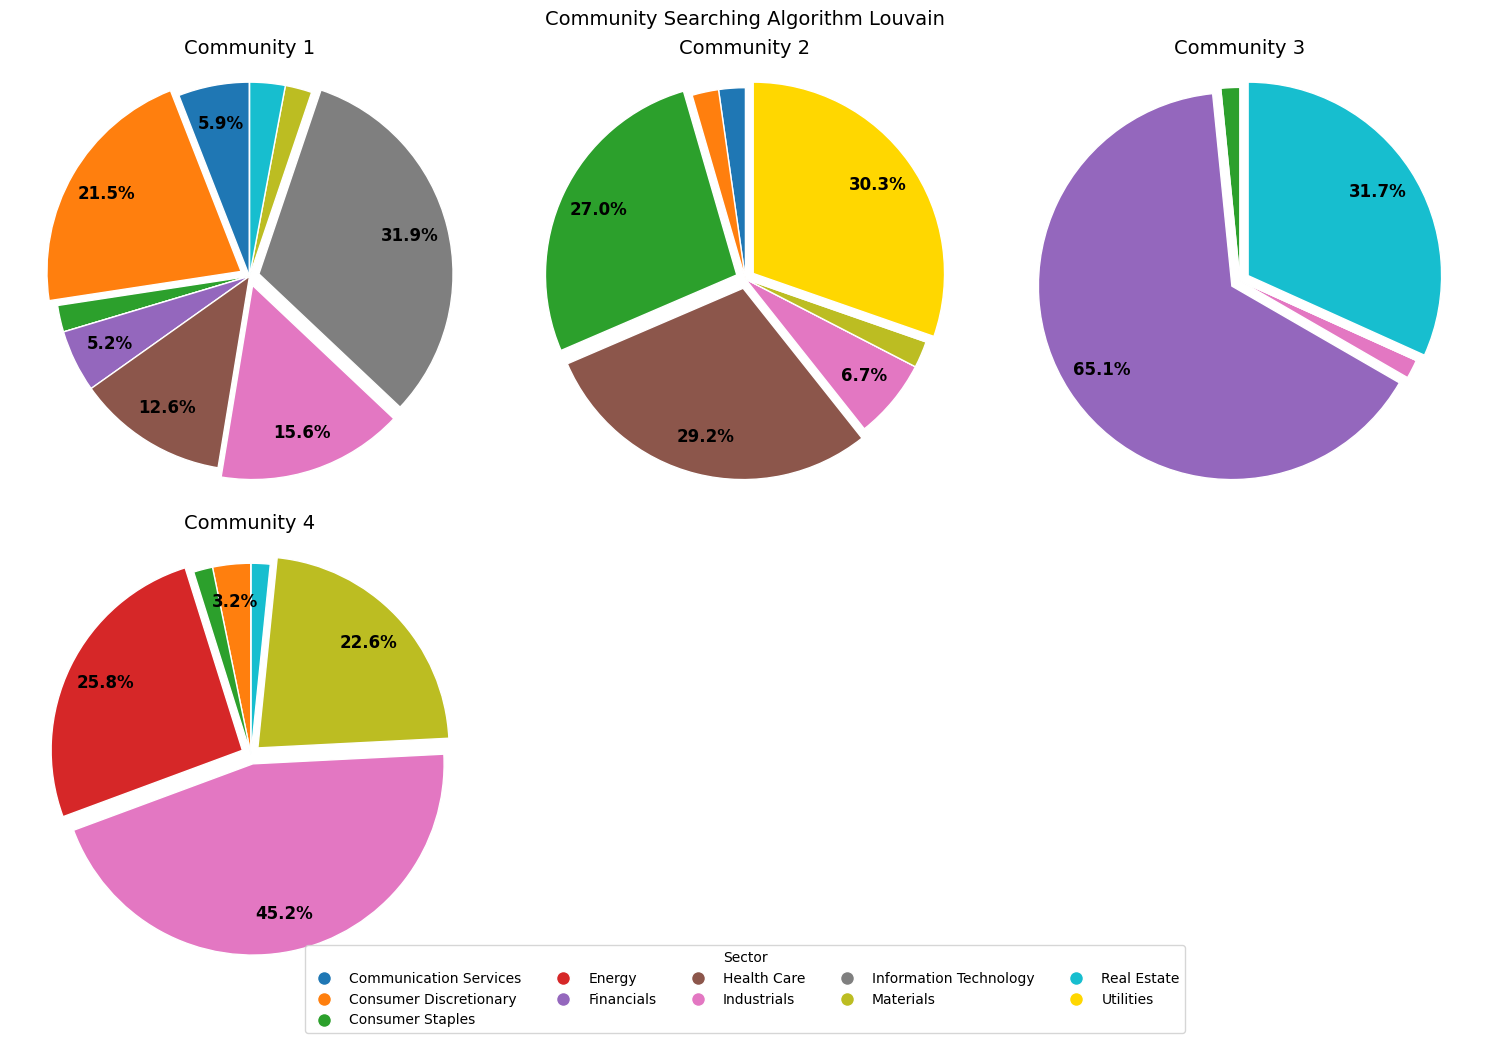

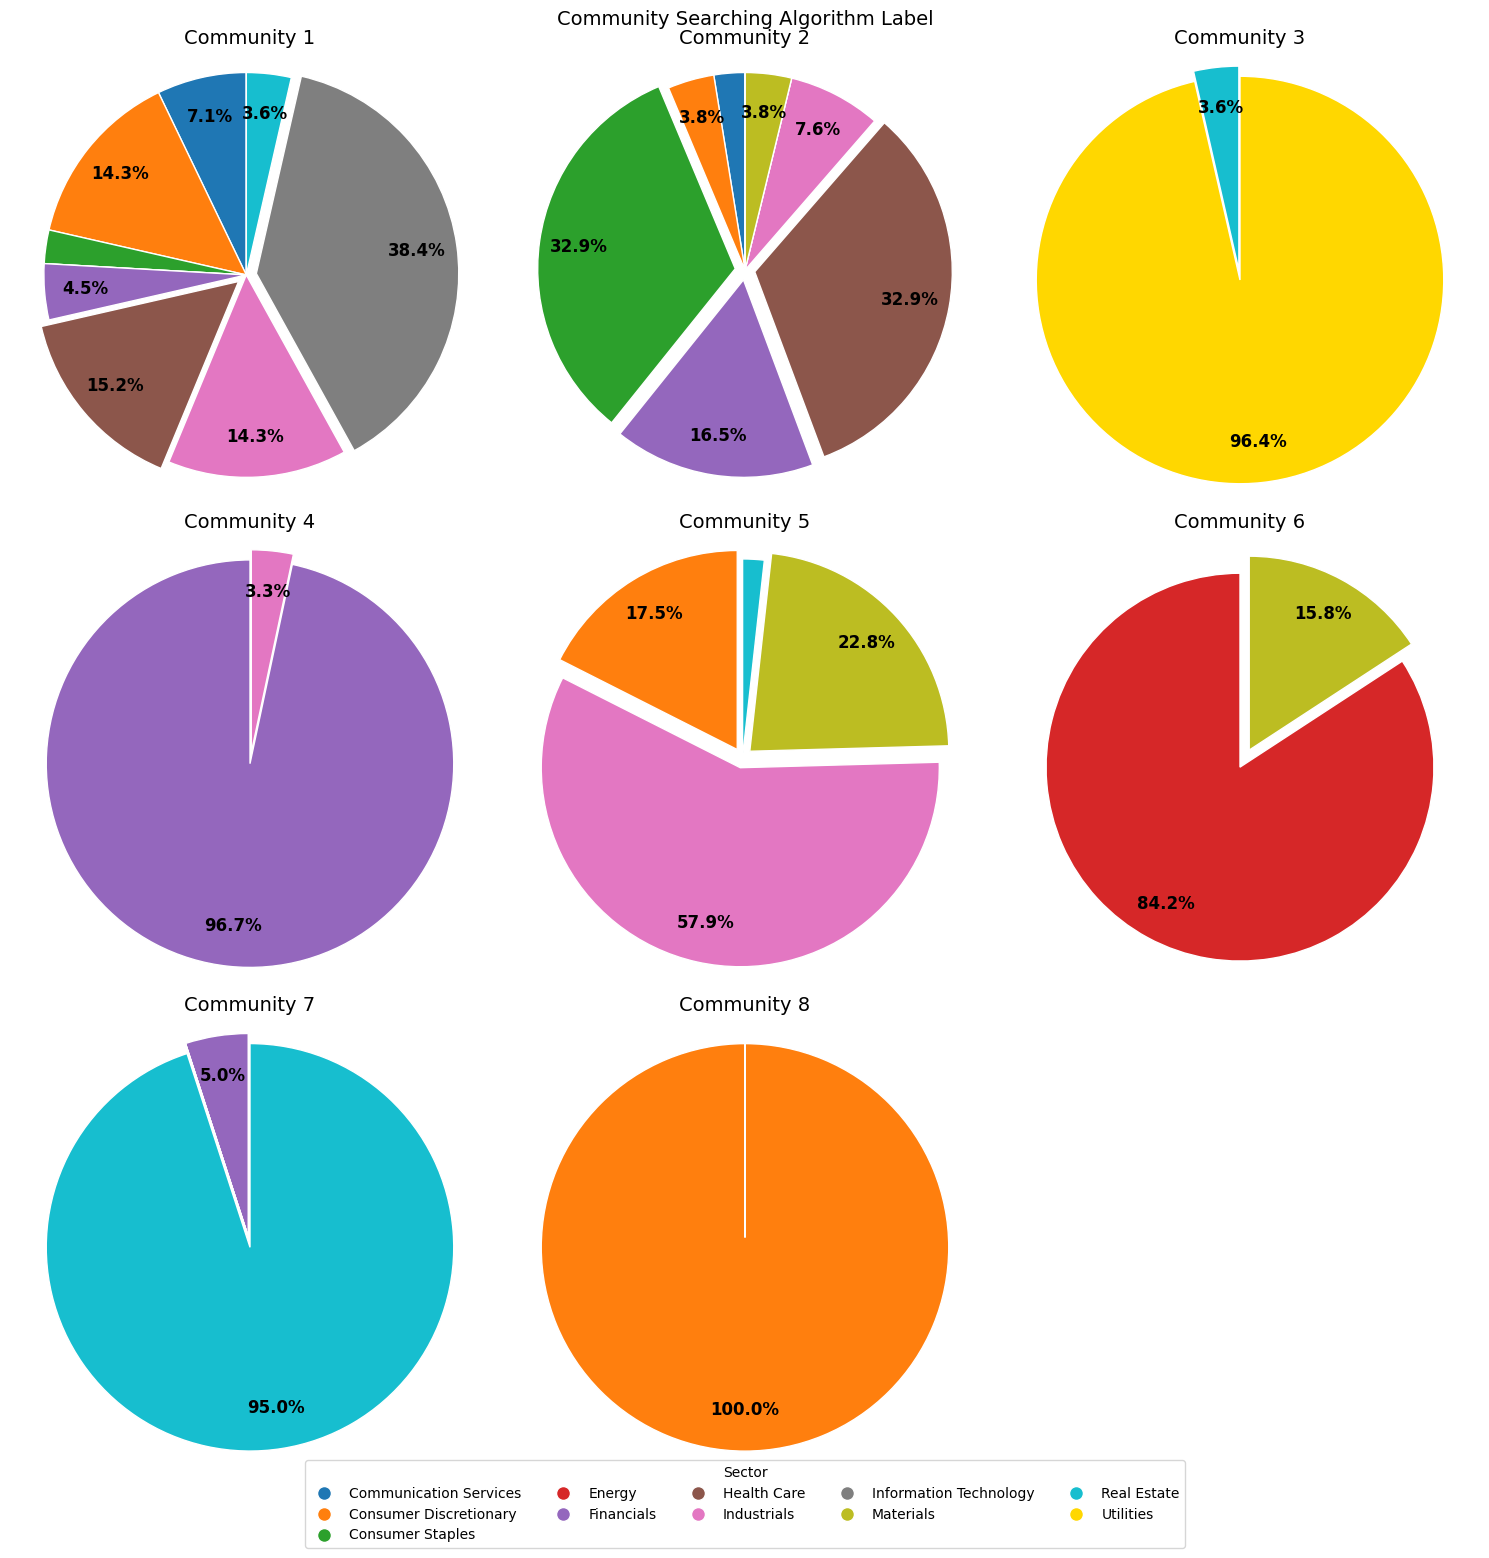

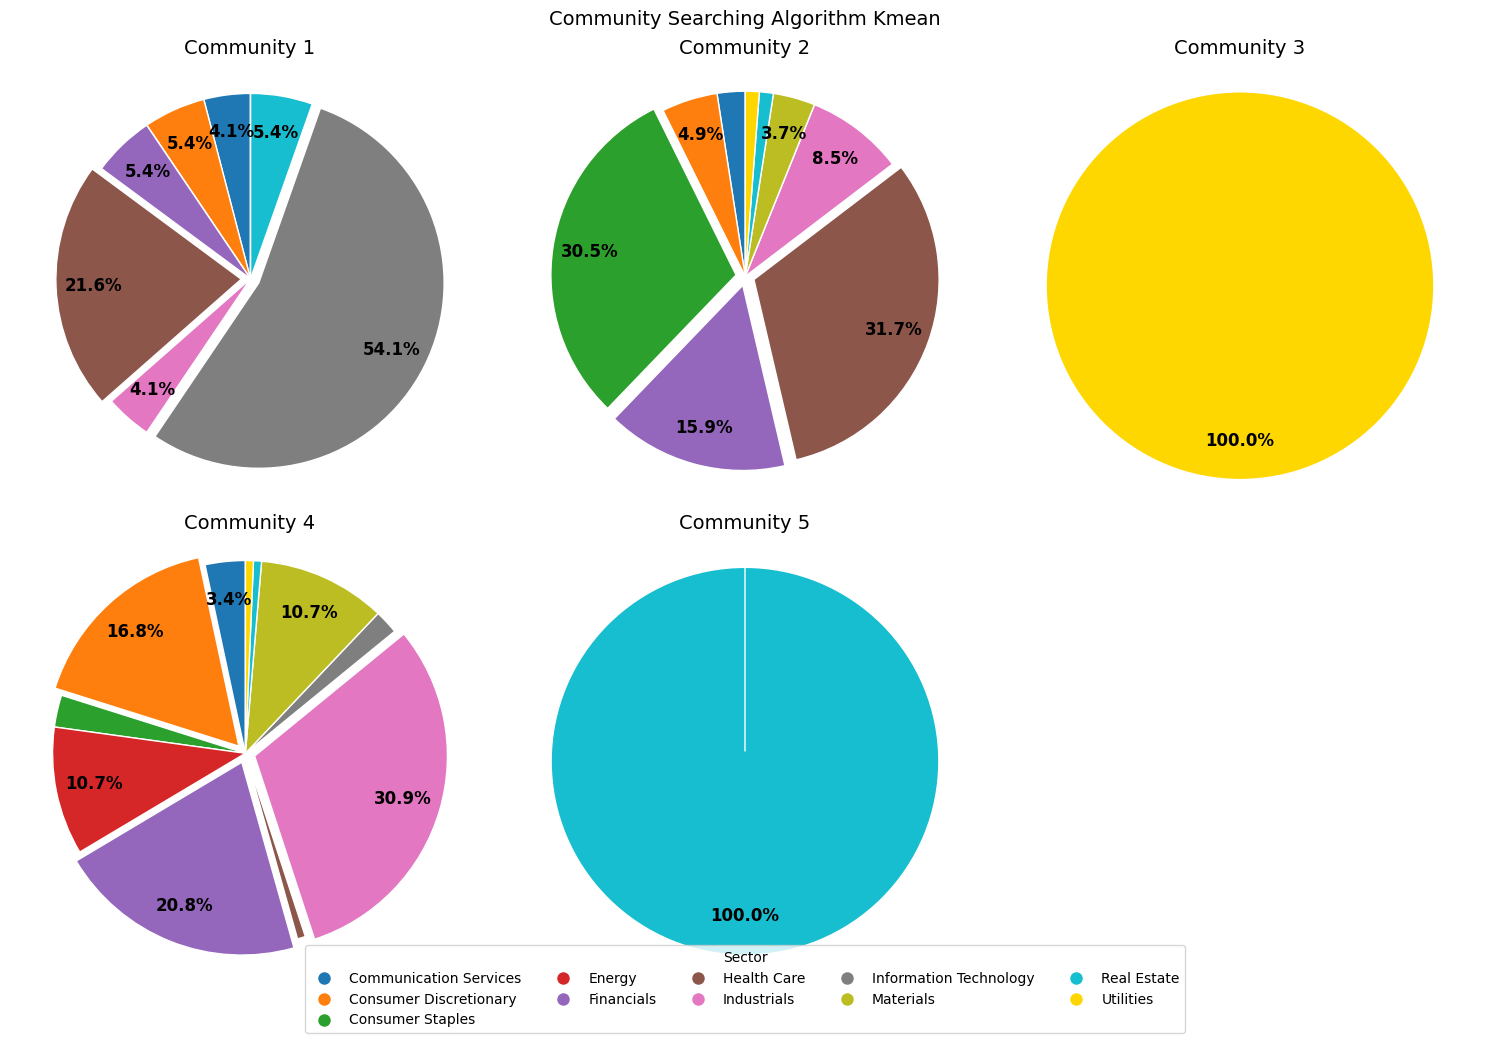

In [9]:
for i in ('Louvain', 'Label', 'Kmean'):
    portfolio.mesoscopic_filter()
    portfolio.community_discover(algo = i)
    portfolio.plot_communities_pie(title = i)
    plt.show()

## Portfolio Building

### Weight Distribution asset

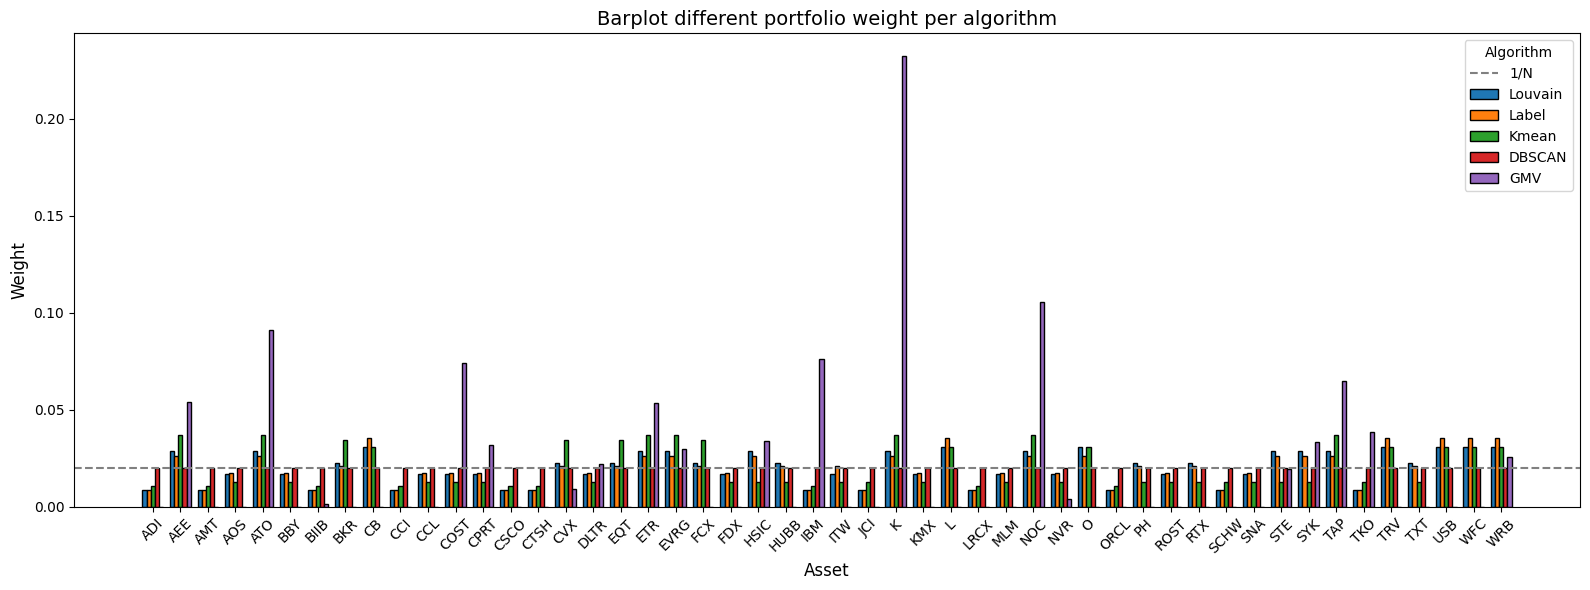

In [10]:
# create portfolio class
num_asset = 50
price_data_sampled = price_data.sample(n= num_asset, axis=1, random_state=42)
price_data_sampled = price_data_sampled[sorted(price_data_sampled.columns)]
returns = price_data_sampled.pct_change().dropna() 
portfolio = Portfolio(data_csv, price_data = price_data_sampled, returns = returns)
portfolio.C_g = portfolio.mesoscopic_filter()
weights_dict = {}

# Find weights of each portfolio
#alg_list = ["Louvain", "Label", "Kmean", "DBSCAN", "GMV"]
alg_list = ["Louvain", "Label", "Kmean", "DBSCAN"]
for alg in alg_list: 
    communities = portfolio.community_discover(algo=alg)
    weights = portfolio.portfolio_building(community=True, algo=alg)
    weights_dict[alg] = weights
weights_dict['GMV'] = portfolio.portfolio_building(community=False)
weights_df = pd.DataFrame(weights_dict, index=price_data_sampled.columns)

# Plot
labels = weights_df.index.to_list()           
algorithms = weights_df.columns.to_list()     
n_algos = len(algorithms)
x = np.arange(len(labels))                    
width = 0.15                                  

fig, ax = plt.subplots(figsize=(16, 6))
for i, algo in enumerate(algorithms):
    bar_positions = x + (i - n_algos/2) * width + width/2
    ax.bar(bar_positions, weights_df[algo], width=width, label=algo, edgecolor='black')

ax.axhline(1/num_asset, color='gray', linestyle='--', linewidth=1.5, label='1/N')
ax.set_title("Barplot different portfolio weight per algorithm", fontsize=14)
ax.set_ylabel("Weight", fontsize=12)
ax.set_xlabel("Asset", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(title="Algorithm")
plt.tight_layout()
plt.show()

## Back-test

### Fine-Tuning

====== Start Louvain ======
Cluster found: 4
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.0030569027959412424), 'Sharpe Ratio': np.float64(1.40897928612633), 'Number of Cluster': 4}
Cluster found: 4
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.3540998079883617), 'Sharpe Ratio': np.float64(-0.13868661244427521), 'Number of Cluster': 4}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1822646636848992), 'Sharpe Ratio': np.float64(0.6650715051832798), 'Number of Cluster': 3}
Cluster found: 3
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5028751094174141), 'Sharpe Ratio': np.float64(1.4131569249264255), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-0

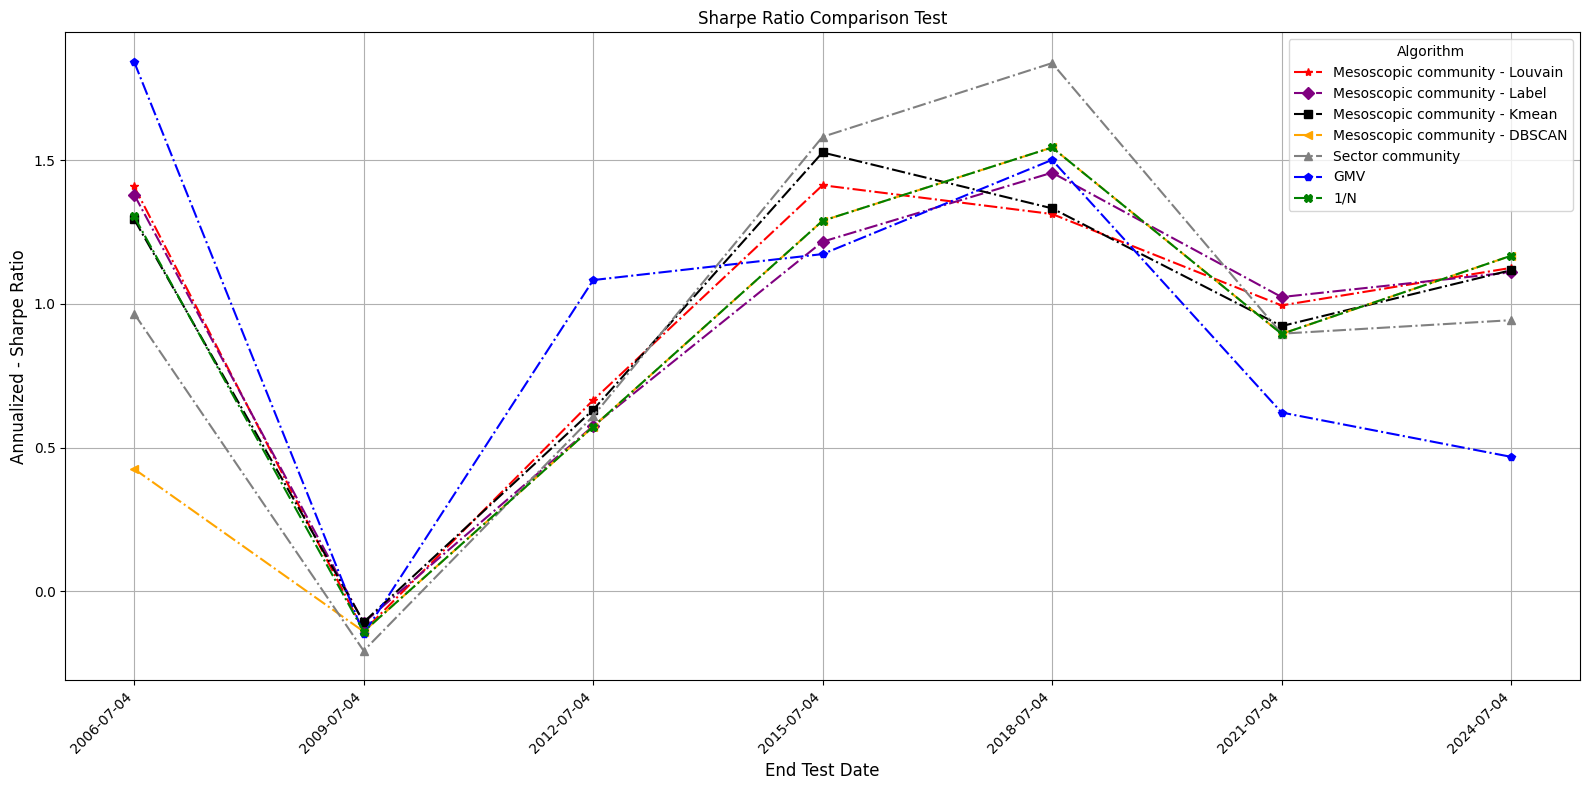

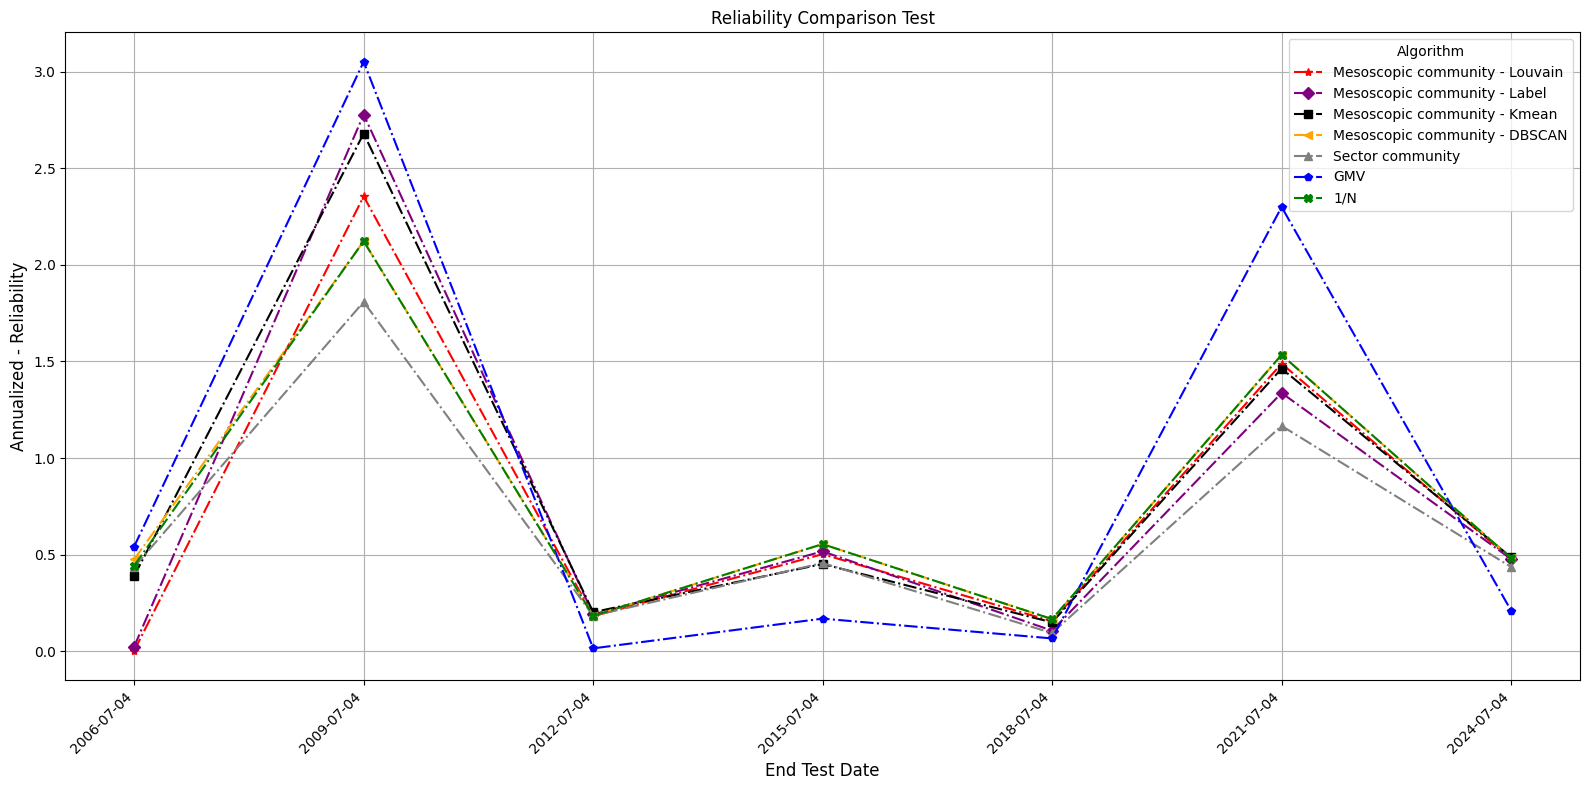

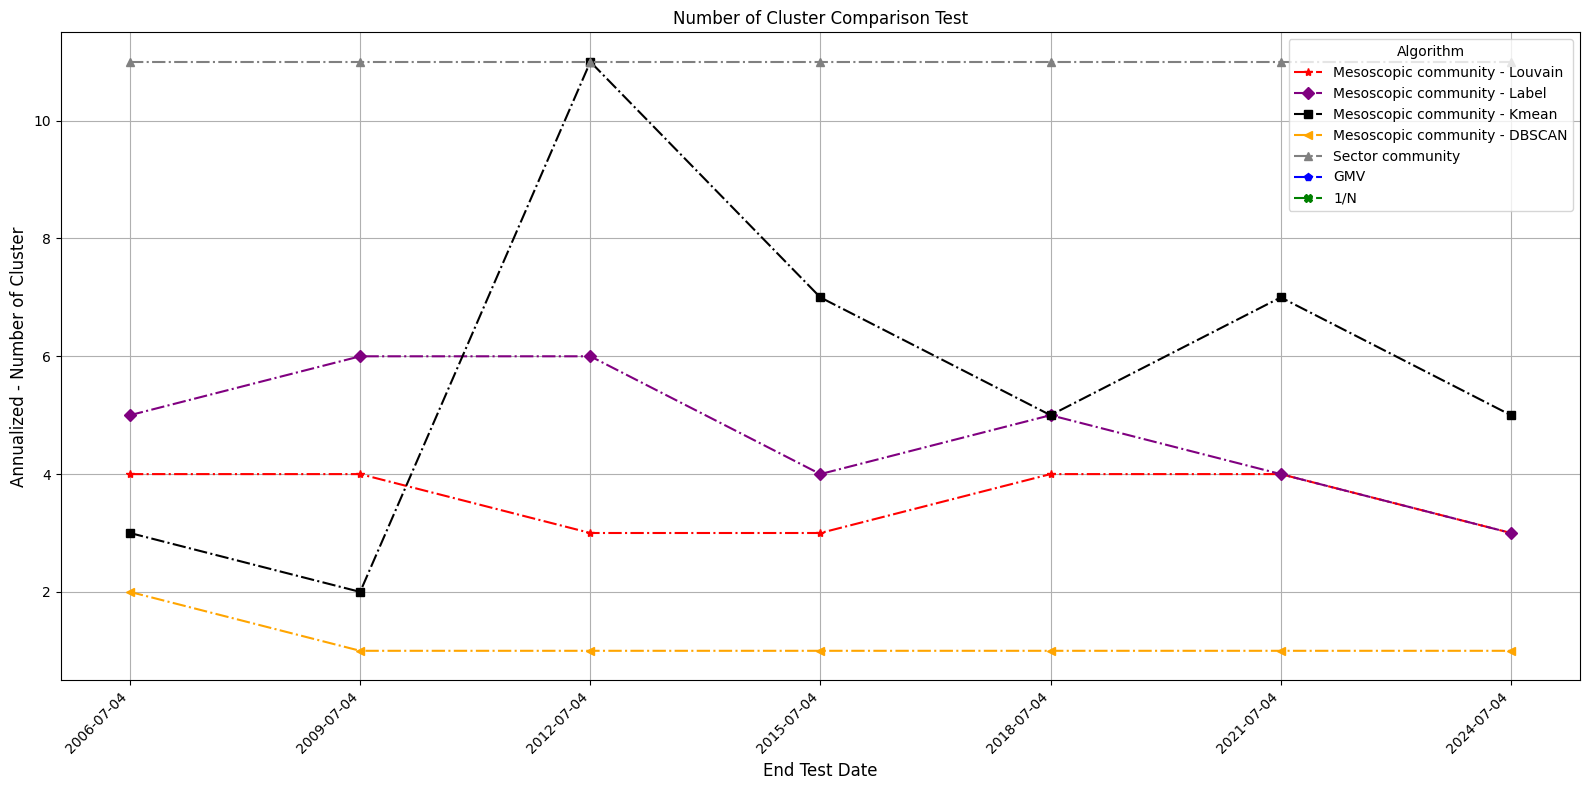

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.9688 │                0.7377 │                      3.5714 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9504 │                0.7761 │                      4.7143 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.9598 │                0.832  │                      5.7143 │
├────┼────────────────────────────────┼─

In [11]:
model = ["Louvain", "Label","Kmean","DBSCAN", "Sector","GMV", "Equal"]
results = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = False, verbose = True, fine_tuning = True)

method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df = plot_results_backtest(results, method_labels, markers, colors)

====== Start Louvain ======
Cluster found: 4
{'start': Timestamp('2003-01-04 00:00:00'), 'end': Timestamp('2006-07-04 00:00:00'), 'Reliability': np.float64(0.0030569027959412424), 'Sharpe Ratio': np.float64(1.40897928612633), 'Number of Cluster': 4}
Cluster found: 4
{'start': Timestamp('2006-01-04 00:00:00'), 'end': Timestamp('2009-07-04 00:00:00'), 'Reliability': np.float64(2.3540998079883617), 'Sharpe Ratio': np.float64(-0.13868661244427521), 'Number of Cluster': 4}
Cluster found: 3
{'start': Timestamp('2009-01-04 00:00:00'), 'end': Timestamp('2012-07-04 00:00:00'), 'Reliability': np.float64(0.1822646636848992), 'Sharpe Ratio': np.float64(0.6650715051832798), 'Number of Cluster': 3}
Cluster found: 3
{'start': Timestamp('2012-01-04 00:00:00'), 'end': Timestamp('2015-07-04 00:00:00'), 'Reliability': np.float64(0.5028751094174141), 'Sharpe Ratio': np.float64(1.4131569249264255), 'Number of Cluster': 3}
Cluster found: 4
{'start': Timestamp('2015-01-04 00:00:00'), 'end': Timestamp('2018-0

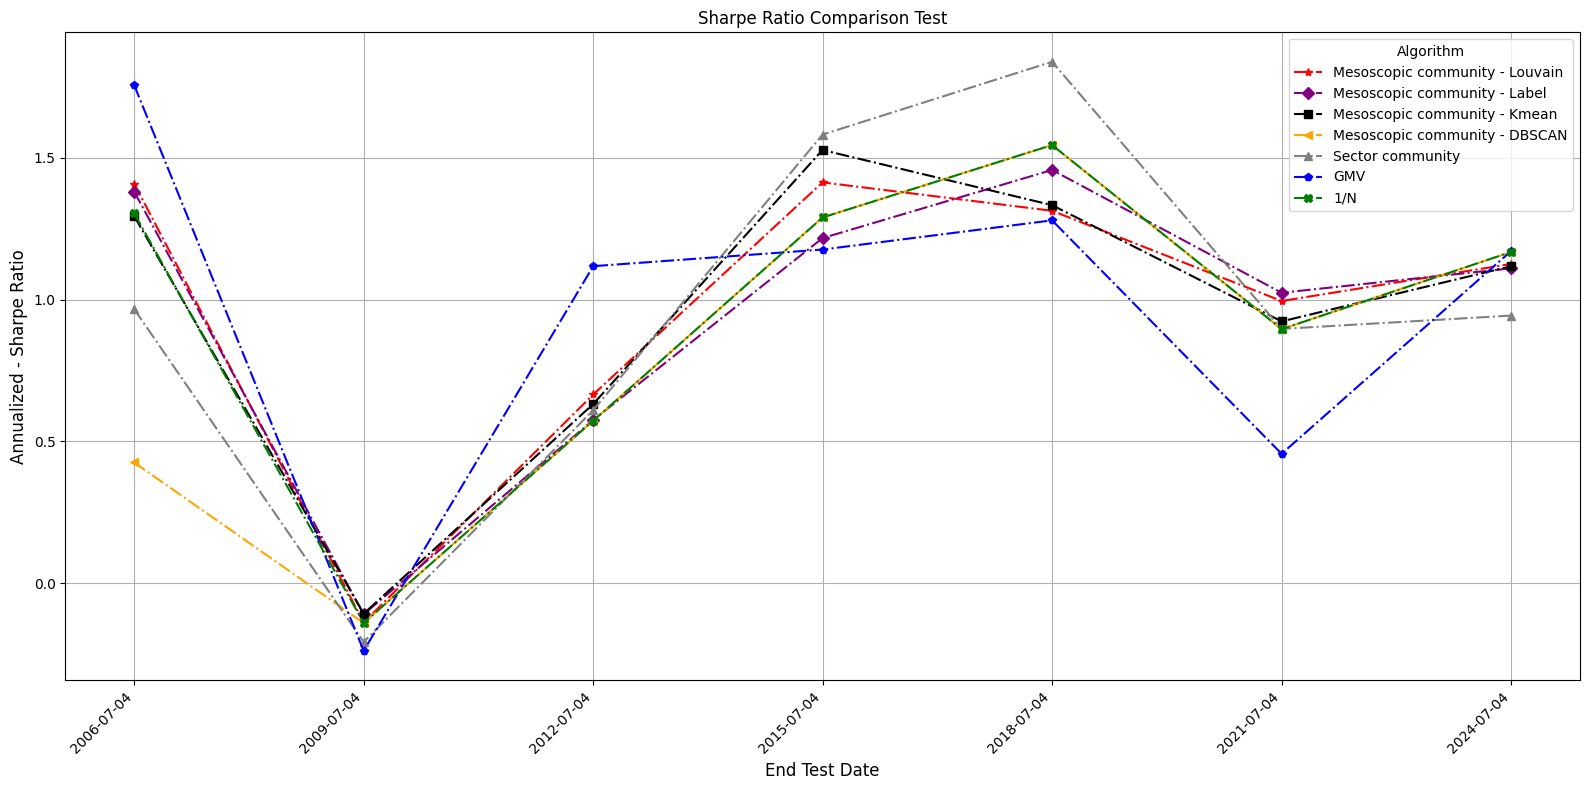

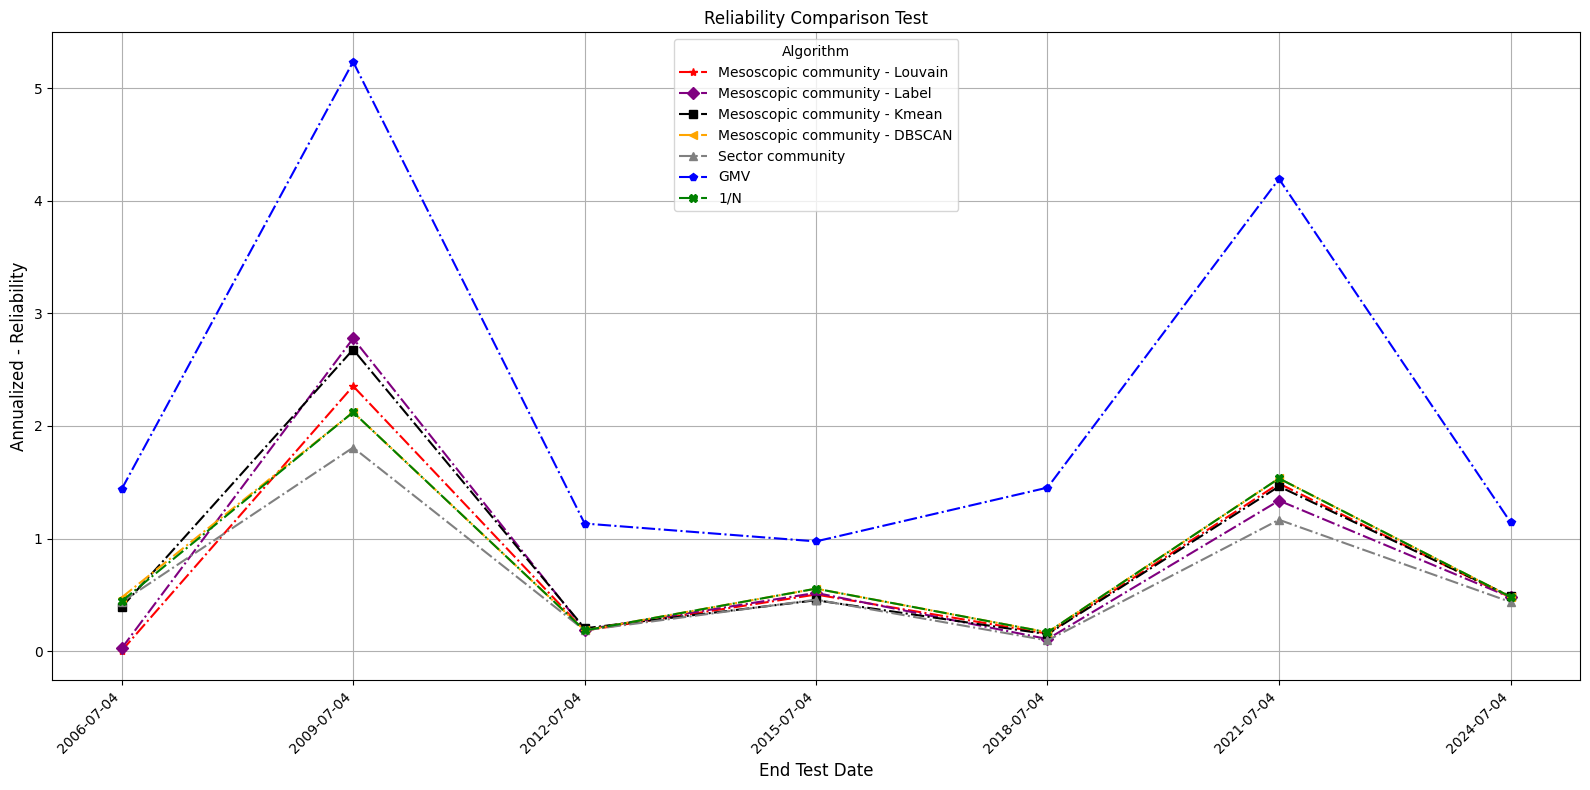

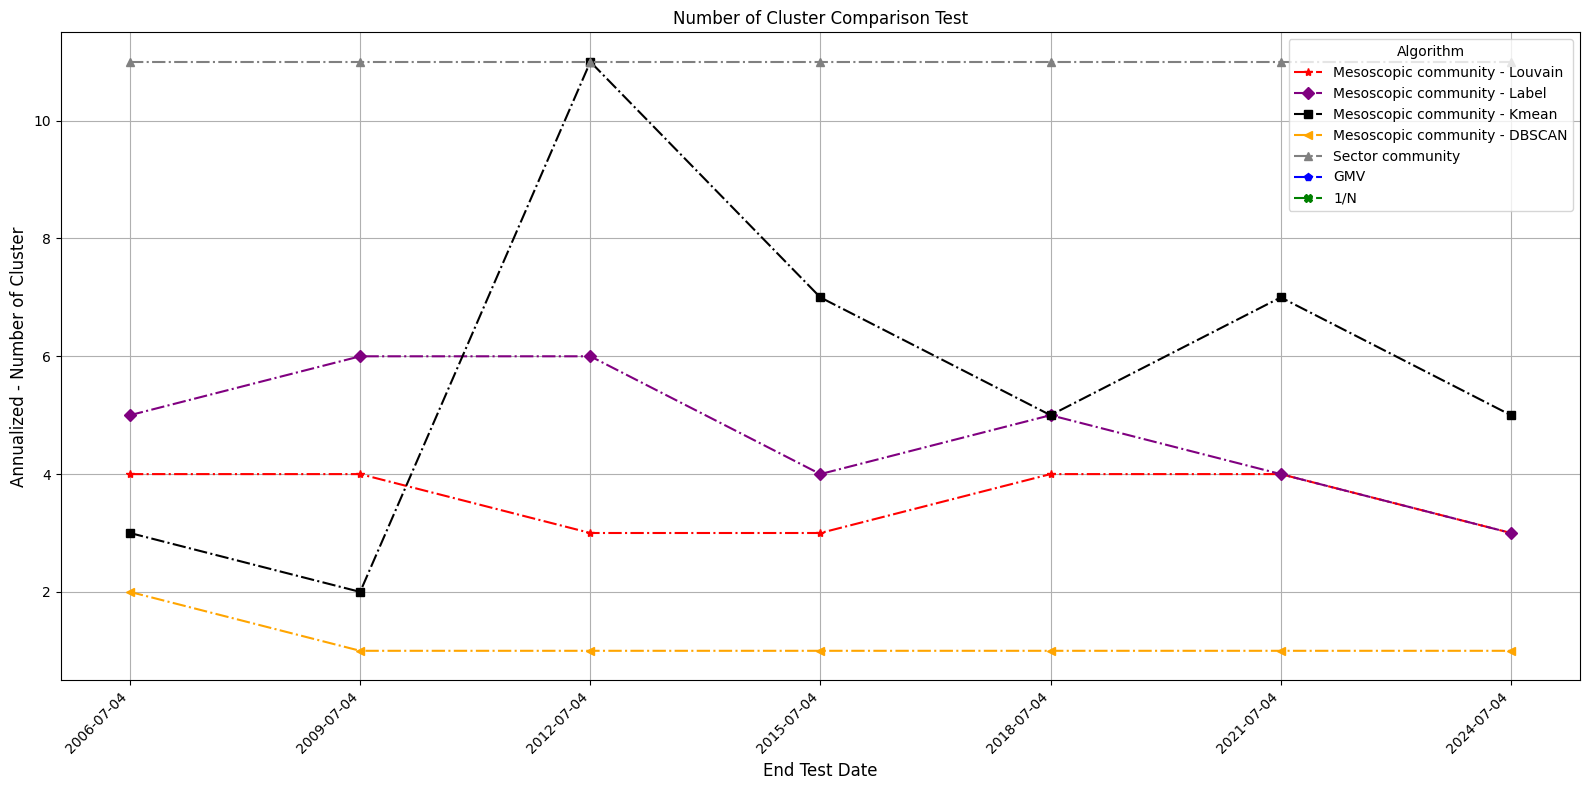

╒════╤════════════════════════════════╤═════════════════════════╤═══════════════════════╤═════════════════════════════╕
│    │ Method                         │   Average Sharpe Ratio  │   Average Reliability │   Average Number of Cluster │
╞════╪════════════════════════════════╪═════════════════════════╪═══════════════════════╪═════════════════════════════╡
│  0 │ Mesoscopic community - Louvain │                  0.9688 │                0.7377 │                      3.5714 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  1 │ Mesoscopic community - Label   │                  0.9504 │                0.7761 │                      4.7143 │
├────┼────────────────────────────────┼─────────────────────────┼───────────────────────┼─────────────────────────────┤
│  2 │ Mesoscopic community - Kmean   │                  0.9598 │                0.832  │                      5.7143 │
├────┼────────────────────────────────┼─

In [12]:
model = ["Louvain", "Label", "Kmean", "DBSCAN", "Sector","GMV", "Equal"]
results_short = {}
for m in model:
    print(f"====== Start {m} ======")
    portfolio = Portfolio(data_csv, price_data = price_data)
    results_short[f"{m}"] = backtest_fun(portfolio, train_months = 36 , burn_period_month  = 6, test_months =18, model = m, short = True, verbose = True, fine_tuning = True)
method_labels = {
        "Louvain": "Mesoscopic community - Louvain",
        "Label": "Mesoscopic community - Label",
        "Kmean": "Mesoscopic community - Kmean",
        "DBSCAN": "Mesoscopic community - DBSCAN",
        "Sector": "Sector community",
        "GMV": "GMV",
        "Equal": "1/N"
    }

markers = {
        "Louvain": "*",
        "Label": "D",
        "Kmean": "s",
        "DBSCAN": "<",
        "Sector": "^",
        "GMV": "p",
        "Equal": "X"
    }

colors = {
        "Louvain": "red",
        "Label": "purple",
        "Kmean": "black",
        "DBSCAN": "orange",
        "Sector": "grey",
        "GMV": "blue",
        "Equal": "green"
    }

summary_df_short = plot_results_backtest(results_short, method_labels, markers, colors)